In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
# убираем scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [2]:
import itertools
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [3]:
# константы для работы с временными диапазонами

# вчерашняя дата
yesterday = [(datetime.date.today() - datetime.timedelta(days=2)).strftime('%Y-%m-%d'),
            (datetime.date.today() - datetime.timedelta(days=2)).strftime('%Y-%m-%d')]
# последние 7 дней (без учета текущей даты)
week_dates = [(datetime.date.today() - datetime.timedelta(days=7)).strftime('%Y-%m-%d'), \
(datetime.date.today() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')]
# текущий месяц (без учета текущей даты)
month_dates = [datetime.date.today().strftime('%Y-%m-') + '01', \
(datetime.date.today() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')]

# выставляем даты для отчета
query_dates = ['2019-06-01', '2019-07-31'];

# выставляем даты для целевого признака по оттоку
churn_query_dates = ['2019-06-01', '2019-06-31'];

# формат даты
fmt = '%Y-%m-%d'

In [4]:
# функция для расчета признаков, связанных с сессиями пользователей (например, avgdaylag (средний кол-во дней между сессиями))
def func(a):
    i1, i2 = itertools.tee(iter(a))
    next(i2)
    res = [(int(round((datetime.strptime(y, fmt) - datetime.strptime(x, fmt)).total_seconds() / 60))) / 1440
    for x, y in zip(i1, i2)] # or just zip in Python 3\n"
    return round(np.mean(res),2)

from datetime import datetime

In [5]:
# здесь выставляем первое число месяца, на который прогнозируем отток

reportDate = datetime(2019, 8, 1)

sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey'})
sns.set(palette='Blues')

In [6]:
##Получим данные по сессиям за период. В нашем случае за три месяца (март, апрель, май 2019)

In [7]:
sessions = pd.read_csv('devtodev_Sql_wizard_22062019_0918.csv', sep=';')

In [8]:
sessions.head()

,sessions.Country,sessions.devtodev_ID,sessions.App_version,sessions.Date,sessions.User_level,"TO_TIMESTAMP(sessions.Date, 'YYYY-MM-DD HH24:MI:SS')","TO_TIMESTAMP(sessions.Date, 'YYYY-MM-DD')"
0,Ukraine,13077563,1.0.70,1554066950000,3,2019-04-01 00:15:50,2019-04-01
1,Ukraine,13077563,1.0.70,1554067159000,3,2019-04-01 00:19:19,2019-04-01
2,Ukraine,13077563,1.0.70,1554067161000,3,2019-04-01 00:19:21,2019-04-01
3,Ukraine,13077563,1.0.70,1554067383000,3,2019-04-01 00:23:03,2019-04-01
4,Ukraine,13077563,1.0.70,1554067387000,3,2019-04-01 00:23:07,2019-04-01


In [9]:
sessions.describe()

,sessions.devtodev_ID,sessions.Date,sessions.User_level
count,51275644.00,51275644.00,51275644.00
mean,10588777.58,1556708714066.73,10.96
std,3266766.56,1516092710.55,4.81
min,108.00,1554066000000.00,3.00
25%,9426704.00,1555401789000.00,7.00
50%,11752556.00,1556718701000.00,11.00
75%,12999128.00,1558011408000.00,14.00
max,13952972.00,1559336399000.00,55.00


In [10]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51275644 entries, 0 to 51275643
Data columns (total 7 columns):
sessions.Country                                        object
sessions.devtodev_ID                                    int64
sessions.App_version                                    object
sessions.Date                                           int64
sessions.User_level                                     int64
TO_TIMESTAMP(sessions.Date, 'YYYY-MM-DD HH24:MI:SS')    object
TO_TIMESTAMP(sessions.Date, 'YYYY-MM-DD')               object
dtypes: int64(3), object(4)
memory usage: 2.7+ GB


In [11]:
##Создадим общий dataframe для пользователей, куда будем добавлять агрегированные данные. Посчитаем кол-во сессий на Advertising_ID, используя SessionStartTimestamp в качестве ID сессии

In [12]:
%%time

df_main = sessions.groupby('sessions.devtodev_ID')[['sessions.Date']]\
    .count().reset_index().sort_values(by='sessions.Date', ascending=False)

Wall time: 2.05 s


In [13]:
##Запишем дни сессий в порядке возрастания массивом в колонку SessionStartDate

In [14]:
df_main['SessionStartDate'] = [sorted(list(set(sessions["TO_TIMESTAMP(sessions.Date, 'YYYY-MM-DD')"].loc[sessions['sessions.devtodev_ID'] == x['sessions.devtodev_ID']])))  
    for _, x in df_main.iterrows()]

In [15]:
##Посчитаем среднюю продолжительность перерыва между днями, в течение которых были сессии

In [16]:
df_main['sessions_avgdaylag'] = df_main.apply(lambda x: func(x['SessionStartDate']), axis=1)

C:\Users\ibelaya\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ibelaya\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:
##Если у пользователя был один активный день, то avgdaylag будет равен кол-ву дней с этого дня и до даты отчета

In [18]:
tempSer = df_main[df_main['sessions_avgdaylag'].isnull()]['SessionStartDate'].apply(
     lambda x: round((int(round((reportDate - datetime.strptime(x[0], fmt)).total_seconds() / 60))) / 1440))

In [19]:
df_main['sessions_avgdaylag'] = df_main['sessions_avgdaylag'].fillna(tempSer)

In [20]:
##Посчитаем кол-во дней, прошешдишх с последней сессии пользователя от даты формирования отчета

In [21]:
temp = sessions.groupby('sessions.devtodev_ID')[["TO_TIMESTAMP(sessions.Date, 'YYYY-MM-DD')"]].max().reset_index()
temp['sessions_daysSinceLastSession'] = temp["TO_TIMESTAMP(sessions.Date, 'YYYY-MM-DD')"].apply(
    lambda x: round((int(round((reportDate - datetime.strptime(x, fmt)).total_seconds() / 60))) / 1440))
df_main = df_main.join(temp.drop(["TO_TIMESTAMP(sessions.Date, 'YYYY-MM-DD')"], axis=1).set_index('sessions.devtodev_ID'), on='sessions.devtodev_ID')

In [22]:
##Посчитаем количество дней, когда пользователь был активен в приложении

In [23]:
df_main['sessions_totaldaysactive'] = df_main['SessionStartDate'].apply(lambda x: len(x))

In [24]:
##Удалим массив уникальных дат с сессиями и переименуем столбец SessionStartTimestamp

In [25]:
df_main = df_main.drop(['SessionStartDate'], axis=1).rename(index=str, columns={
    "sessions.Date": "sessions_totalnumber"
})

In [26]:
##СЧИТАЕМ CHURN И ПРОСТАВЛЯЕМ TARGET FEATURE

In [27]:
sessions = pd.read_csv('devtodev_Sql_wizard_22062019_0949.csv', sep=';')

In [28]:
df_sessions_churn = sessions.groupby('sessions.devtodev_ID')[['sessions.Date']]\
    .count().reset_index().sort_values(by='sessions.Date', ascending=False)

In [29]:
##Посмотрим, какие Advertising_ID, из тех, что присутствуют в общем dataFrame за период, вернулись в прогнозируем периоде. Если Advertising_ID найден, ставим "0" (неотток), в противном случае - "1" (отто

In [30]:
df_main.columns

Index([u'sessions.devtodev_ID', u'sessions_totalnumber', u'sessions_avgdaylag',
       u'sessions_daysSinceLastSession', u'sessions_totaldaysactive'],
      dtype='object')

In [31]:
df_main['churned'] = df_main['sessions.devtodev_ID'].isin(df_sessions_churn['sessions.devtodev_ID']).apply(lambda x: 0 if x is True else 1)

In [32]:
df_main['churned'].value_counts(normalize=True)

1   0.70
0   0.30
Name: churned, dtype: float64

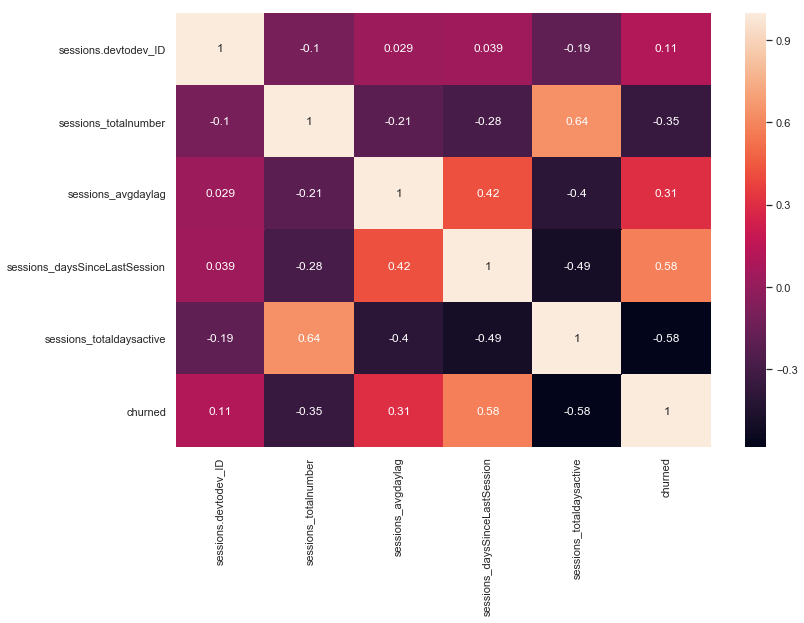

In [33]:
sns.heatmap(df_main[[f for f in df_main.columns if 'sessions' in f or 'churned' in f]].corr(), annot=True);

In [34]:
df_main.tail()

,sessions.devtodev_ID,sessions_totalnumber,sessions_avgdaylag,sessions_daysSinceLastSession,sessions_totaldaysactive,churned
123328,13211115,1,110.00,110.00,1,1
123307,13210930,1,112.00,112.00,1,1
123294,13210808,1,111.00,111.00,1,1
123281,13210725,1,113.00,113.00,1,1
94992,12780851,1,81.00,81.00,1,1


In [35]:
df_main.shape

(189985, 6)

In [36]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189985 entries, 44819 to 94992
Data columns (total 6 columns):
sessions.devtodev_ID             189985 non-null int64
sessions_totalnumber             189985 non-null int64
sessions_avgdaylag               189985 non-null float64
sessions_daysSinceLastSession    189985 non-null float64
sessions_totaldaysactive         189985 non-null int64
churned                          189985 non-null int64
dtypes: float64(2), int64(4)
memory usage: 10.1+ MB


# Exploratory data analysis

# FEATURE ENGINEERING

In [51]:
# общее количество сессий за 2 месяца меньше 200
df_main['sessions_totalnumber_less_500'] = df_main['sessions_totalnumber'].apply(lambda x: 1 if x < 500 else 0)

In [52]:
# общее количество сессий за 2 месяца меньше 100
df_main['sessions_totalnumber_less_200'] = df_main['sessions_totalnumber'].apply(lambda x: 1 if x < 200 else 0)

In [53]:
# общее количество активных дней за 1 месяц меньше 10
df_main['sessions_totaldaysactive_less_10'] = df_main['sessions_totaldaysactive'].apply(lambda x: 1 if x < 10 else 0)

In [54]:
df_main['sessions_avgdaylag_greater_20'] = df_main['sessions_avgdaylag'].apply(lambda x: 1 if x > 20.5 else 0)
df_main['sessions_avgdaylag_greater_10'] = df_main['sessions_avgdaylag'].apply(lambda x: 1 if x > 10 else 0)
df_main['sessions_avgdaylag_greater_15'] = df_main['sessions_avgdaylag'].apply(lambda x: 1 if x > 15 else 0)
df_main['sessions_daysSinceLastSession_equalsgreater_19'] = df_main['sessions_daysSinceLastSession'].apply(lambda x: 1 if x >= 19 else 0)
df_main['sessions_totaldaysactive_equalsless_2'] = df_main['sessions_totaldaysactive'].apply(lambda x: 1 if x <= 2 else 0)
df_main['sessions_totalnumber_equalsless_5'] = df_main['sessions_totalnumber'].apply(lambda x: 1 if x <= 5 else 0)

In [55]:
def label_race(row):
    if (row['sessions_avgdaylag_greater_10'] == 1 and row['sessions_totaldaysactive_equalsless_2'] == 1 and
        row['sessions_daysSinceLastSession_equalsgreater_19'] == 1 and row['sessions_totalnumber_equalsless_5'] == 1):
        return 1
    else:
        return 0

In [56]:
df_main['sessions_isPassive'] = df_main.apply(lambda row: label_race (row),axis=1)

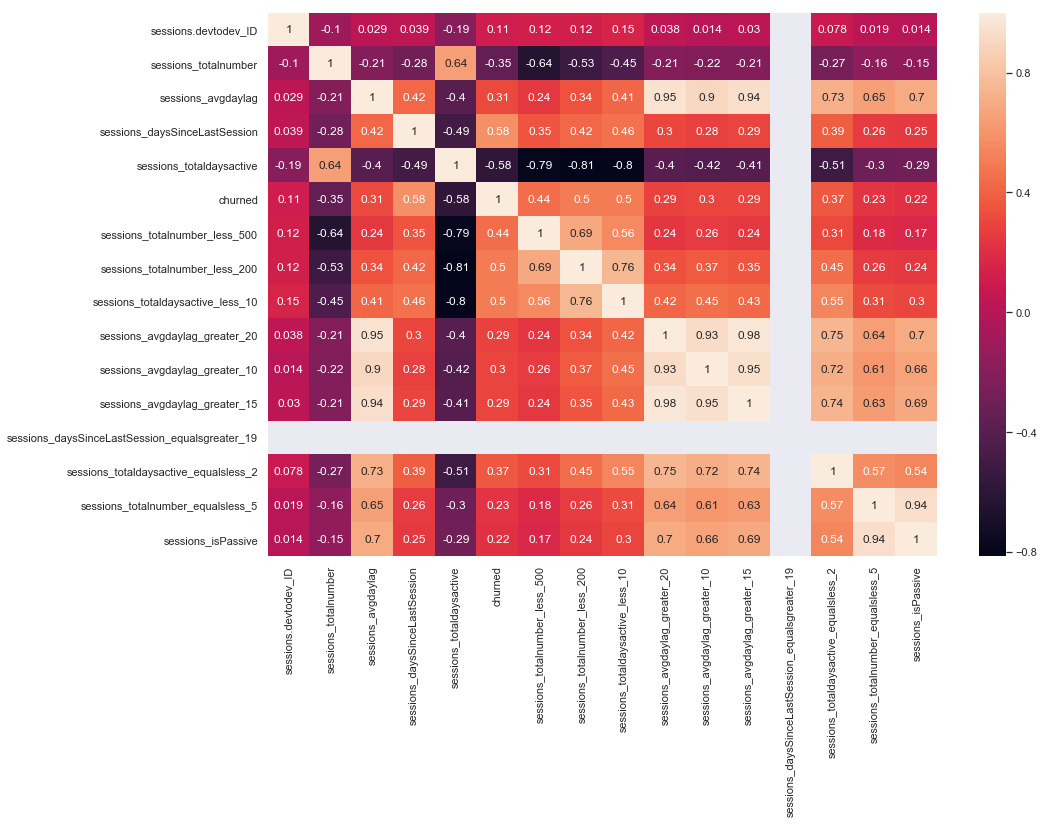

In [57]:
fig, ax = plt.subplots(figsize=(15,10))
# sns.heatmap(df_main.corr());
sns.heatmap(df_main[[f for f in df_main.columns if 'sessions' in f or 'churned' in f]].corr(), annot=True);

In [58]:
####RANDOM FOREST

In [59]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import f1_score
from collections import Counter

In [60]:
y = df_main['churned']
X = df_main.drop('churned', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.33, random_state=42)

# df_small = X_valid

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, max_depth=6,)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=10)))

0.8925358950014302


In [63]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [64]:
print(classification_report(y_valid, forest.predict(X_valid), target_names=['non-churned', 'churned']))

             precision    recall  f1-score   support

non-churned       0.87      0.75      0.81     18903
    churned       0.90      0.95      0.92     43793

avg / total       0.89      0.89      0.89     62696



In [65]:
forest_params = {
    'max_depth': list(range(5,40,10)),
    
}

forest_grid = GridSearchCV(forest, forest_params, cv=10, n_jobs=-1, verbose=True, scoring='f1') #try randomsearchgrid

In [66]:
forest_grid.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.4min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 15, 25, 35]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1', verbose=True)

In [67]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 5}, 0.9253416148499913)

In [68]:
print(classification_report(y_valid, forest_grid.predict(X_valid), target_names=['non-churned', 'churned']))

             precision    recall  f1-score   support

non-churned       0.88      0.74      0.80     18903
    churned       0.90      0.95      0.92     43793

avg / total       0.89      0.89      0.89     62696



In [69]:
####GradientBoosting (LIGHT)

In [70]:
import lightgbm as lgb

# Set params
# Scores ~0.784 (without tuning and early stopping)
params = {
    'boosting_type': 'gbdt',
    'max_depth' : -1,
    'objective': 'binary',
    'nthread': 3, # Updated from nthread
    'num_leaves': 34,
    'learning_rate': 0.1,
    'max_bin': 1024,
    'subsample_for_bin': 200,
    'subsample': 1,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 5,
    'reg_lambda': 10,
    'min_split_gain': 0.5,
    'min_child_weight': 1,
    'min_child_samples': 5,
    'scale_pos_weight': 1,
    'num_class' : 1,
    'metric' : 'binary_logloss',
    'num_iterations' : 200
}

gridParams = {
    'learning_rate': [0.1],
    'n_estimators': [40],
    'num_leaves': [31],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [42], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1.2, 1.4],
    'reg_lambda' : [1.2, 1.4]
}

lgbm = lgb.LGBMClassifier(
    boosting_type= params['boosting_type'],
    objective = params['objective'],
    n_jobs = -1, # Updated from 'nthread'
    silent = True,
    max_depth = params['max_depth'],
    max_bin = params['max_bin'],
    subsample_for_bin = params['subsample_for_bin'],
    subsample = params['subsample'],
    subsample_freq = params['subsample_freq'],
    min_split_gain = params['min_split_gain'],
    min_child_weight = params['min_child_weight'],
    min_child_samples = params['min_child_samples'],
    scale_pos_weight = params['scale_pos_weight'],
    learning_rate = params['learning_rate'],
    num_iterations=params['num_iterations'],
    num_leaves=params['num_leaves']
)

In [71]:
lgbm.fit(X_train, y_train)

C:\Users\ibelaya\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_bin=1024,
        max_depth=-1, min_child_samples=5, min_child_weight=1,
        min_split_gain=0.5, n_estimators=100, n_jobs=-1,
        num_iterations=200, num_leaves=34, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=1, silent=True, subsample=1,
        subsample_for_bin=200, subsample_freq=1)

In [72]:
# F1 score для litegb - параметры НЕоптимизированы

report = classification_report(y_valid, lgbm.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.86      0.76      0.81     18903
    Churned       0.90      0.95      0.93     43793

avg / total       0.89      0.89      0.89     62696



C:\Users\ibelaya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [73]:
%%time
lgbm_grid = GridSearchCV(lgbm, gridParams,
                    verbose=True,
                    cv=5,
                    n_jobs=-1, scoring='f1')
lgbm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.2min finished
C:\Users\ibelaya\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Wall time: 2min 11s


In [74]:
lgbm_grid.best_params_, lgbm_grid.best_score_

({'boosting_type': 'gbdt',
  'colsample_bytree': 0.65,
  'learning_rate': 0.1,
  'n_estimators': 40,
  'num_leaves': 31,
  'objective': 'binary',
  'random_state': 42,
  'reg_alpha': 1.2,
  'reg_lambda': 1.4,
  'subsample': 0.75},
 0.9262982371536306)

In [75]:
# F1 score для litegb - параметры НЕоптимизированы

report = classification_report(y_valid, lgbm.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.86      0.76      0.81     18903
    Churned       0.90      0.95      0.93     43793

avg / total       0.89      0.89      0.89     62696



C:\Users\ibelaya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [76]:
# F1 score для litegb - параметры оптимизированы

report = classification_report(y_valid, lgbm_grid.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.87      0.77      0.81     18903
    Churned       0.90      0.95      0.93     43793

avg / total       0.89      0.89      0.89     62696



C:\Users\ibelaya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [77]:
####XGBOOST

In [78]:
from IPython.display import display

import re
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.grid_search import GridSearchCV

C:\Users\ibelaya\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\ibelaya\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [79]:
X = np.array(df_main.drop('churned', 1))
training_features = np.array(df_main.drop('churned', 1).columns)
#X = preprocessing.scale(X)  --- not needed for XGboost?
y = np.array(df_main['churned'])

In [80]:
xgb = xgb.XGBClassifier()
scores = cross_validation.cross_val_score(xgb, X, y, cv=5, n_jobs=-1, verbose=True, scoring='f1')
xgb.fit(X_train, y_train)
print(scores)
print('F1: %.3f stdev: %.2f' % (np.mean(np.abs(scores)), np.std(scores)))

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s finished


[0.00248588 0.03355253 0.11305104 0.13877051 0.82204861]
F1: 0.222 stdev: 0.30


In [81]:
report = classification_report(y_valid, xgb.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.86      0.77      0.81     18903
    Churned       0.90      0.95      0.93     43793

avg / total       0.89      0.89      0.89     62696



C:\Users\ibelaya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [82]:
xgbgridparams = {'learning_rate':[0, 0.001, 0.002, 0.004, 0.006, 0.008, 0.010, 0.1], 
       'reg_lambda':[0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]}

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgbgridparams,
    scoring='f1',
    n_jobs=-1,
    refit=True,
    verbose=True,
    cv=5)
xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_params_)
print(xgb_grid.best_score_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed: 10.7min finished


{'learning_rate': 0.1, 'reg_lambda': 0.1}
0.925854470768


In [83]:
report = classification_report(y_valid, xgb_grid.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.86      0.77      0.81     18903
    Churned       0.90      0.95      0.93     43793

avg / total       0.89      0.89      0.89     62696



C:\Users\ibelaya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [84]:
####CONFUSION MATRIX ДЛЯ LGBM

C:\Users\ibelaya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[14438  4465]
 [ 2262 41531]]


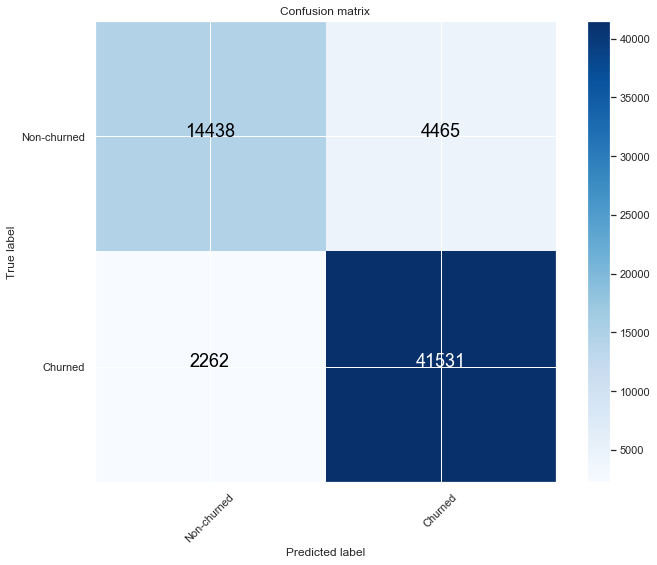

In [85]:
# Воспользуемся функцией построения матрицы ошибок из документации sklearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 18}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_valid, lgbm.predict(X_valid))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()